In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from time import perf_counter
from svgpath2mpl import parse_path

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import gamerotation


class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))
    
def find_gametime(q, secsleft):
    time = 0
    if q in [1, 2, 3, 4]:
        time += (q - 1) * 720 + (720 - secsleft)
    elif q > 4:
        time +=  4 * 720 + (q - 5) * 5 * 60 + (300 - secsleft)
    
    return time

def find_game_event(q):
    if q < 5:
        return "Q" + str(q)
    else:
        return "OT" + str(q - 4)
    
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def load_season(home, away, date, season):
    ROOT_DIR = os.path.dirname(os.path.abspath("top_level_file.txt"))
    PBP_DIR = os.path.join(ROOT_DIR, "data/pbp_data")
    if season == "1516":
        PBP = os.path.join(PBP_DIR, "NBA_PBP_2015-16.csv")
    elif season == "1617":
        PBP = os.path.join(PBP_DIR, "NBA_PBP_2016-17.csv")
    elif season == "1718":
        PBP = os.path.join(PBP_DIR, "NBA_PBP_2017-18.csv")
    elif season == "1819":
        PBP = os.path.join(PBP_DIR, "NBA_PBP_2018-19.csv")
    elif season == "1920":
        PBP = os.path.join(PBP_DIR, "NBA_PBP_2019-20.csv")
    elif season == "2021":
        PBP = os.path.join(PBP_DIR, "NBA_PBP_2020-21.csv")
    elif season == "new":
        PBP = os.path.join(ROOT_DIR, "data/raw/output_pbp.csv")
        
    df = pd.read_csv(PBP)
    df['Date'] = pd.to_datetime(df['Date'])
    df_game = df[(df['Date'] == date) & (df['HomeTeam'] == home) & (df['AwayTeam'] == away)]
    
    return df_game

def last_name_correction(last):
    print("----")
    print(last)
    if "Jr." in last:
        last = last.replace(" Jr.", "")
    elif "Sr." in last:
        last = last.replace(" Sr.", "")
    elif "I" in last:
        last = last.replace(" I", "")
    elif "II" in last:
        last = last.replace(" II", "")
    elif "III" in last:
        last = last.replace(" III", "")
    elif "porzingis" in last.lower():
        last = "Porz"
    elif "doncic" in last.lower():
        last = "Don"
    elif "marjanovic" in last.lower():
        last = "Marjanov"
    elif "bogdanovic" in last.lower():
        last = "Bogdan"
    else:
        last = last
    print(last)
    print("----")
    
    return last
    

In [59]:
# Marker SVG

ROOT_DIR = os.path.dirname(os.path.abspath("top_level_file.txt"))
MADE_2PT = os.path.join(ROOT_DIR, "img/made_2pt.png")
MISS_2PT = os.path.join(ROOT_DIR, "img/miss_2pt.png")
MADE_3PT = os.path.join(ROOT_DIR, "img/made_3pt.png")
MISS_3PT = os.path.join(ROOT_DIR, "img/miss_3pt.png")
MADE_FT = os.path.join(ROOT_DIR, "img/made_1pt.png")
MISS_FT = os.path.join(ROOT_DIR, "img/miss_1pt.png")
RBD_OFF = os.path.join(ROOT_DIR, "img/rbd_off.png")
RBD_DFF = os.path.join(ROOT_DIR, "img/rbd_dff.png")
FOUL = os.path.join(ROOT_DIR, "img/foul.png")
ASST = os.path.join(ROOT_DIR, "img/asst.png")

In [60]:
home_team = "ATL"
away_team = "MIL"
date = datetime(2021, 6, 29)
season = "new"
home_color = "Red"
away_color = "Green"
top = cm.get_cmap(away_color + "s_r", 128) # away
bottom = cm.get_cmap(home_color + "s", 128) # home

df_game = load_season(home=home_team, away=away_team, date=date, season=season)
df_game

,URL,GameType,Location,Date,Time,WinningTeam,Quarter,SecLeft,AwayTeam,AwayPlay,...,FreeThrowNum,EnterGame,LeaveGame,TurnoverPlayer,TurnoverType,TurnoverCause,TurnoverCauser,JumpballAwayPlayer,JumpballHomePlayer,JumpballPoss
2189,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,1,720,MIL,Jump ball: B. Lopez vs. C. Capela (G. Antetoko...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B. Lopez - lopezbr01,C. Capela - capelca01,G. Antetokounmpo - antetgi01
2190,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,1,700,MIL,J. Holiday misses 3-pt jump shot from 26 ft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2191,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,1,697,MIL,Offensive rebound by B. Lopez,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2192,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,1,694,MIL,K. Middleton misses 3-pt jump shot from 25 ft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2193,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,1,694,MIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2623,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,4,25,MIL,Defensive rebound by T. Antetokounmpo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2624,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,4,21,MIL,T. Antetokounmpo makes 2-pt layup from 1 ft,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2625,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,4,21,MIL,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2626,/boxscores/202106290ATL.html,playoff,State Farm Arena Atlanta Georgia,2021-06-29,8:30 PM,ATL,4,0,MIL,End of 4th quarter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
total_game_time_secs = 0
graph_time_lines_list = [0]
graph_event_labels_list = ["START"]
for i in df_game['Quarter'].unique():
    if i in [1, 2, 3, 4]:
        total_game_time_secs += 12 * 60
    else:
        total_game_time_secs += 5 * 60
    graph_time_lines_list.append(find_gametime(i, 0))
    graph_event_labels_list.append(find_game_event(i))

timespace = np.arange(total_game_time_secs)

In [62]:
df_game['PlusMinus'] = df_game['HomeScore'] - df_game['AwayScore']
df_game['GameTime'] = np.zeros(df_game.shape[0])
for i in df_game.index:
    df_game['GameTime'][i] = find_gametime(df_game['Quarter'][i], df_game['SecLeft'][i])

<ipython-input-62-072fc4dadc97>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_game['GameTime'][i] = find_gametime(df_game['Quarter'][i], df_game['SecLeft'][i])


# Game Rotation

In [63]:
nba_teams = teams.get_teams()
if away_team == "BRK":
    away_team = "BKN"

home_team_dict = [team for team in nba_teams if team['abbreviation'] == home_team][0]
away_team_dict = [team for team in nba_teams if team['abbreviation'] == away_team][0]
home_team_id = home_team_dict['id']
away_Team_id = away_team_dict['id']

gamefinder = leaguegamefinder.LeagueGameFinder(team_id_nullable=home_team_id)

games = gamefinder.get_data_frames()[0]
games['GAME_DATE'] = pd.to_datetime(games['GAME_DATE'])
games = games[(games['GAME_DATE'] == date)]
game_id = games['GAME_ID'].item()
rot = gamerotation.GameRotation(game_id).get_data_frames()
rotation = rot[1]
rotation_away = rot[0]
og_columns = df_game.columns
rotation_away

,GAME_ID,TEAM_ID,TEAM_CITY,TEAM_NAME,PERSON_ID,PLAYER_FIRST,PLAYER_LAST,IN_TIME_REAL,OUT_TIME_REAL,PLAYER_PTS,PT_DIFF,USG_PCT
0,0042000304,1610612749,Milwaukee,Bucks,200782,P.J.,Tucker,0.0,6090.0,8,-3.0,0.136
1,0042000304,1610612749,Milwaukee,Bucks,200782,P.J.,Tucker,9930.0,20160.0,0,-11.0,0.111
2,0042000304,1610612749,Milwaukee,Bucks,201572,Brook,Lopez,0.0,4880.0,2,-4.0,0.118
3,0042000304,1610612749,Milwaukee,Bucks,201572,Brook,Lopez,8650.0,11840.0,0,-7.0,0.077
4,0042000304,1610612749,Milwaukee,Bucks,201572,Brook,Lopez,14400.0,19040.0,3,-7.0,0.188
5,0042000304,1610612749,Milwaukee,Bucks,201572,Brook,Lopez,21600.0,26210.0,2,1.0,0.105
6,0042000304,1610612749,Milwaukee,Bucks,201950,Jrue,Holiday,0.0,6090.0,2,-3.0,0.227
7,0042000304,1610612749,Milwaukee,Bucks,201950,Jrue,Holiday,7200.0,12400.0,6,-6.0,0.300
8,0042000304,1610612749,Milwaukee,Bucks,201950,Jrue,Holiday,13110.0,20160.0,5,-10.0,0.250
9,0042000304,1610612749,Milwaukee,Bucks,201950,Jrue,Holiday,21600.0,26210.0,6,1.0,0.368


In [64]:
# HOME
ante_bros = False
short_name_list = []
full_name_list = []
last_name_list = []

for i in rotation.index:
    first = rotation['PLAYER_FIRST'][i][:1]
    first_name = rotation['PLAYER_FIRST'][i]
    if "thana" in first_name.lower():
        ante_bros = True
    last = rotation['PLAYER_LAST'][i]
    last = last_name_correction(last)
        
    short_name_list.append(rotation['PLAYER_FIRST'][i][:1] + "." + " " + rotation['PLAYER_LAST'][i])
    full_name_list.append(rotation['PLAYER_FIRST'][i] + " " + rotation['PLAYER_LAST'][i])
    last_name_list.append(last)
    
short_name_list = list(set(short_name_list))
full_name_list = list(set(full_name_list))
last_name_list = list(set(last_name_list))

if ante_bros:
    last_name_list.append("T. Antetokounmpo")

# TRACKING DICTIONARIES

rotation_dict = {}
shot_dict = {}
ft_dict = {}
rbd_dict = {}
foul_dict = {}
asst_dict = {}

for i, name in enumerate(last_name_list):
    rotation_dict[name] = []
    shot_dict[name] = []
    ft_dict[name] = []
    rbd_dict[name] = []
    foul_dict[name] = []
    asst_dict[name] = []
    df_game[f"home_{i}"] = np.zeros(df_game.shape[0])
    
for name in last_name_list:
    for i in rotation.index:
        if name in rotation['PLAYER_FIRST'][i] + " " + rotation['PLAYER_LAST'][i]:
            rotation_dict[name].append((rotation['IN_TIME_REAL'][i] / 10, rotation['OUT_TIME_REAL'][i] / 10))
        if "Thanasis" in rotation['PLAYER_FIRST'][i]:
            rotation_dict["T. Antetokounmpo"].append((rotation['IN_TIME_REAL'][i] / 10, rotation['OUT_TIME_REAL'][i] / 10))
            
# AWAY
ante_bros = False
short_name_list_away = []
full_name_list_away = []
last_name_list_away = []

for i in rotation_away.index:
    first = rotation_away['PLAYER_FIRST'][i][:1]
    first_name = rotation_away['PLAYER_FIRST'][i]
    if "thana" in first_name.lower():
        ante_bros = True
    last = rotation_away['PLAYER_LAST'][i]
    last = last_name_correction(last)
        
    short_name_list_away.append(rotation_away['PLAYER_FIRST'][i][:1] + "." + " " + rotation_away['PLAYER_LAST'][i])
    full_name_list_away.append(rotation_away['PLAYER_FIRST'][i] + " " + rotation_away['PLAYER_LAST'][i])
    last_name_list_away.append(last)
    
short_name_list_away = list(set(short_name_list_away))
full_name_list_away = list(set(full_name_list_away))
last_name_list_away = list(set(last_name_list_away))

if ante_bros:
    last_name_list_away.append("T. Antetokounmpo")

print(last_name_list_away)
print(full_name_list_away)
print(short_name_list_away)

# TRACKING DICTIONARIES

rotation_dict_away = {}
shot_dict_away = {}
ft_dict_away = {}
rbd_dict_away = {}
foul_dict_away = {}
asst_dict_away = {}

for i, name in enumerate(last_name_list_away):
    rotation_dict_away[name] = []
    shot_dict_away[name] = []
    ft_dict_away[name] = []
    rbd_dict_away[name] = []
    foul_dict_away[name] = []
    asst_dict_away[name] = []
    df_game[f"away_{i}"] = np.zeros(df_game.shape[0])
    
for name in last_name_list_away:
    for i in rotation_away.index:
        if name in rotation_away['PLAYER_FIRST'][i] + " " + rotation_away['PLAYER_LAST'][i]:
            rotation_dict_away[name].append((rotation_away['IN_TIME_REAL'][i] / 10, rotation_away['OUT_TIME_REAL'][i] / 10))
        elif "Thanasis" in rotation_away['PLAYER_FIRST'][i]:
            rotation_dict_away["T. Antetokounmpo"].append((rotation_away['IN_TIME_REAL'][i] / 10, rotation_away['OUT_TIME_REAL'][i] / 10))


----
Williams
Williams
----
----
Williams
Williams
----
----
Williams
Williams
----
----
Williams
Williams
----
----
Gallinari
Gallinari
----
----
Gallinari
Gallinari
----
----
Gallinari
Gallinari
----
----
Snell
Snell
----
----
Capela
Capela
----
----
Capela
Capela
----
----
Capela
Capela
----
----
Capela
Capela
----
----
Bogdanovic
Bogdan
----
----
Bogdanovic
Bogdan
----
----
Bogdanovic
Bogdan
----
----
Bogdanovic
Bogdan
----
----
Dunn
Dunn
----
----
Dunn
Dunn
----
----
Dunn
Dunn
----
----
Collins
Collins
----
----
Collins
Collins
----
----
Collins
Collins
----
----
Collins
Collins
----
----
Fernando
Fernando
----
----
Huerter
Huerter
----
----
Huerter
Huerter
----
----
Huerter
Huerter
----
----
Huerter
Huerter
----
----
Huerter
Huerter
----
----
Reddish
Reddish
----
----
Reddish
Reddish
----
----
Reddish
Reddish
----
----
Reddish
Reddish
----
----
Okongwu
Okongwu
----
----
Okongwu
Okongwu
----
----
Okongwu
Okongwu
----
----
Okongwu
Okongwu
----
----
Mays
Mays
----
----
Knight
Knight

# Shot Markers

In [65]:
# HOME

df_shot = df_game[~pd.isna(df_game["Shooter"])].copy()
df_free = df_game[~pd.isna(df_game["FreeThrowShooter"])].copy()
df_rebound = df_game[~pd.isna(df_game["Rebounder"])].copy()
df_foul = df_game[~pd.isna(df_game["Fouler"])].copy()
df_asst = df_game[~pd.isna(df_game["Assister"])].copy()

for num, name in enumerate(last_name_list):
    df = df_shot[df_shot["Shooter"].str.contains(name)]
    df_ft = df_free[df_free["FreeThrowShooter"].str.contains(name)]
    df_rbd = df_rebound[df_rebound["Rebounder"].str.contains(name)]
    df_fl = df_foul[df_foul["Fouler"].str.contains(name)]
    df_a = df_asst[df_asst["Assister"].str.contains(name)]
    
    # LABELS ON GRAPH
    
    for i in df.index:
        shot_arr = [df["GameTime"][i], 1 if "make" in df["ShotOutcome"][i] else 0, 2 if "2" in df["ShotType"][i] else 3]
        asst_arr = [last_name_list.index(name)]
        if not pd.isna(df["Assister"][i]):
            for n in last_name_list:
                if n in df["Assister"][i]:
                    asst_arr.append(last_name_list.index(n))
        shot_arr.append(asst_arr)
        shot_dict[name].append(shot_arr)
        
        if shot_arr[1] == 1:
            df_game[f"home_{num}"][i] = shot_arr[2]
        
        # RUNNING SCORE
        
    for i in df_ft.index:
        check = 1 if "make" in df_ft["FreeThrowOutcome"][i] else 0
        ft_dict[name].append([df_ft["GameTime"][i], check])
        if check == 1:
            df_game[f"home_{num}"][i] = 1
            
    for i in df_rbd.index:
        rbd_dict[name].append([df_rbd["GameTime"][i], 1 if "offensive" in df_rbd["ReboundType"][i] else 0])
    for i in df_fl.index:
        foul_dict[name].append(df_fl["GameTime"][i])
    for i in df_a.index:
        asst_dict[name].append(df_a["GameTime"][i])
        
    # RUNNING SCORE
    
    df_game[f"home_{num}"] = np.cumsum(df_game[f"home_{num}"])    

# AWAY

for num, name in enumerate(last_name_list_away):
    df = df_shot[df_shot["Shooter"].str.contains(name)]
    df_ft = df_free[df_free["FreeThrowShooter"].str.contains(name)]
    df_rbd = df_rebound[df_rebound["Rebounder"].str.contains(name)]
    df_fl = df_foul[df_foul["Fouler"].str.contains(name)]
    df_a = df_asst[df_asst["Assister"].str.contains(name)]
    
    # LABELS ON GRAPH
    
    for i in df.index:
        shot_arr = [df["GameTime"][i], 1 if "make" in df["ShotOutcome"][i] else 0, 2 if "2" in df["ShotType"][i] else 3]
        asst_arr = [last_name_list_away.index(name)]
        if not pd.isna(df["Assister"][i]):
            for n in last_name_list_away:
                if n in df["Assister"][i]:
                    asst_arr.append(last_name_list_away.index(n))
        shot_arr.append(asst_arr)
        shot_dict_away[name].append(shot_arr)
        
        if shot_arr[1] == 1:
            df_game[f"away_{num}"][i] = shot_arr[2]
        
    for i in df_ft.index:
        check = 1 if "make" in df_ft["FreeThrowOutcome"][i] else 0
        ft_dict_away[name].append([df_ft["GameTime"][i], check])
        if check == 1:
            df_game[f"away_{num}"][i] = 1
    for i in df_rbd.index:
        rbd_dict_away[name].append([df_rbd["GameTime"][i], 1 if "offensive" in df_rbd["ReboundType"][i] else 0])
    for i in df_fl.index:
        foul_dict_away[name].append(df_fl["GameTime"][i])
    for i in df_a.index:
        asst_dict_away[name].append(df_a["GameTime"][i])
        
    df_game[f"away_{num}"] = np.cumsum(df_game[f"away_{num}"])

    print(f"{name}: {shot_dict_away[name]}")


Merrill: []
Teague: [[2120.0, 0, 2, [1]]]
Diakite: [[2717.0, 0, 2, [2]], [2739.0, 0, 2, [2]], [2769.0, 0, 3, [2]]]
Nwora: [[2664.0, 0, 3, [3]], [2807.0, 0, 3, [3]]]
Middleton: [[26.0, 0, 3, [4]], [192.0, 0, 3, [4]], [284.0, 0, 2, [4]], [448.0, 1, 2, [4]], [605.0, 0, 2, [4]], [712.0, 0, 3, [4]], [991.0, 0, 2, [4]], [1175.0, 1, 2, [4, 5]], [1195.0, 1, 2, [4, 11]], [1250.0, 0, 3, [4]], [1523.0, 0, 3, [4]], [1794.0, 0, 2, [4]], [1890.0, 0, 3, [4]], [1977.0, 1, 2, [4]], [1999.0, 1, 2, [4, 5]], [2074.0, 1, 2, [4]], [2150.0, 0, 3, [4]]]
Holiday: [[20.0, 0, 3, [5]], [54.0, 1, 2, [5]], [339.0, 0, 3, [5]], [762.0, 0, 2, [5]], [947.0, 1, 3, [5, 11]], [1003.0, 0, 2, [5]], [1029.0, 0, 2, [5]], [1464.0, 1, 3, [5]], [1627.0, 0, 2, [5]], [1739.0, 1, 2, [5]], [1768.0, 0, 3, [5]], [1920.0, 0, 2, [5]], [2175.0, 1, 2, [5]], [2213.0, 0, 3, [5]], [2355.0, 1, 2, [5]], [2387.0, 0, 2, [5]], [2612.0, 0, 3, [5]]]
Portis: [[516.0, 0, 3, [6]], [644.0, 1, 3, [6, 4]], [677.0, 0, 3, [6]], [1302.0, 0, 3, [6]], [1944.0

Gallinari
Fernando
Capela
Snell
Bogdan
Dunn
Huerter
Knight
Williams
Collins
Okongwu
Reddish
Mays
Merrill
Teague
Diakite
Nwora
Middleton
Holiday
Portis
Connaughton
Tucker
Forbes
Lopez
Antetokounmpo
Bryant
T. Antetokounmpo
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
['TEAM', 'MERRILL', 'TEAGUE', 'DIAKITE', 'NWORA', 'MIDDLETON', 'HOLIDAY', 'PORTIS', 'CONNAUGHTON', 'TUCKER', 'FORBES', 'LOPEZ', 'ANTETOKOUNMPO', 'BRYANT', 'T. ANTETOKOUNMPO']


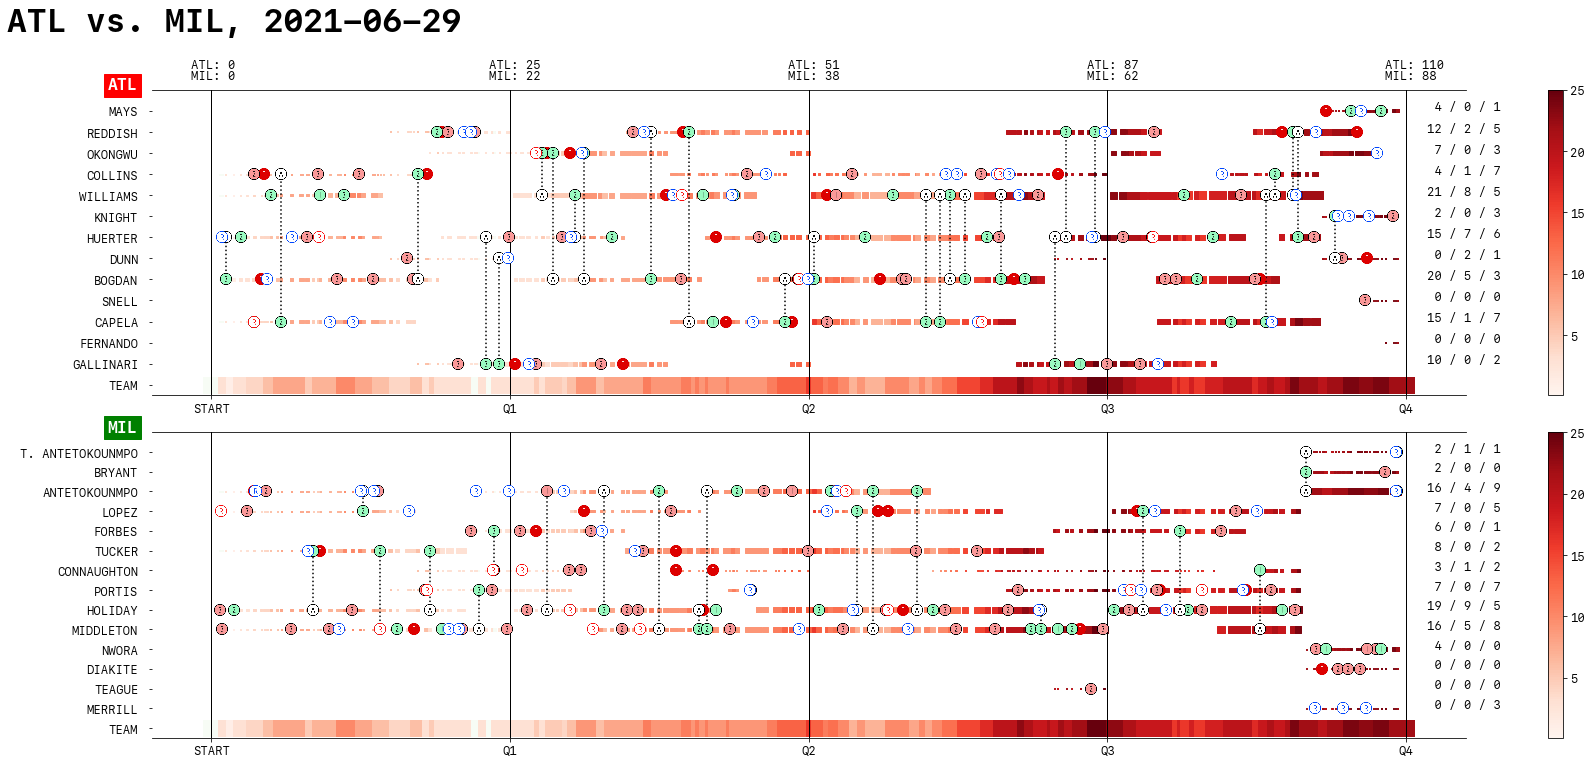

In [66]:
newcolors = np.vstack((top(np.linspace(0, 1, 128)), bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors)
vmin = df_game['PlusMinus'].min()
if vmin == 0:
    vmin = 0.1
vmax = df_game['PlusMinus'].max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)
font = 'SF Mono'
fs = 12
player_cols = list(set(df_game.columns) - set(og_columns))
max_game_score = df_game[player_cols].max().max()
SIZE_REDUCTION_CONST = 8

fig, axs = plt.subplots(2, 1, figsize=(25, 10))
fig.patch.set_facecolor("white")

# QUARTER LINES
# HOME AND AWAY

for i in graph_time_lines_list:
    homescore = home_team + ": " + str(df_game[df_game['GameTime'] == i]["HomeScore"].values[0])
    awayscore = away_team + ": " + str(df_game[df_game['GameTime'] == i]["AwayScore"].values[0])
    axs[0].annotate(homescore, (i - 50, len(short_name_list) + 2), fontsize=fs, annotation_clip=False)
    axs[0].annotate(awayscore, (i - 50, len(short_name_list) + 1.5), fontsize=fs, annotation_clip=False)
    axs[0].set_ylim(0, len(short_name_list) + 3)

for ax in axs:
    ax.set_xticks(graph_time_lines_list)
    ax.set_xticklabels(graph_event_labels_list, fontname=font, fontsize=fs)

# TEAM
for ax in axs:
    for i in graph_time_lines_list:
        ax.axvline(x=i, linewidth=1, color='black')
    total = ax.scatter(df_game['GameTime'], np.zeros(df_game.shape[0]), c=df_game['PlusMinus'], marker='s', s=250, cmap=newcmp, norm=norm)

# PLAYERS
# HOME

y_val = 1
for num, name in enumerate(rotation_dict):
    print(name)
    game_copy = df_game.copy()
    time_list = []
    pm_list = []
    score_list = []
    
    score = str(int(df_game[f'home_{num}'].max())) if df_game[f'home_{num}'].max() > 9 else " " + str(int(df_game[f'home_{num}'].max()))
    stat_line = f"{score} / {len(asst_dict[name])} / {len(rbd_dict[name])}"
    axs[0].annotate(stat_line, (df_game['GameTime'].max() + 50, y_val), fontsize=fs, annotation_clip=False)
    
    for timestamp in rotation_dict[name]:
        time_list.append(game_copy[(timestamp[0] < game_copy['GameTime']) & (game_copy['GameTime'] < timestamp[1])]['GameTime'])
        pm_list.append(game_copy[(timestamp[0] < game_copy['GameTime']) & (game_copy['GameTime'] < timestamp[1])]['PlusMinus'])
        score_list.append(game_copy[(timestamp[0] < game_copy['GameTime']) & (game_copy['GameTime'] < timestamp[1])][f'home_{num}'])
    time_list = pd.concat(time_list, sort=False)
    pm_list = pd.concat(pm_list, sort=False)
    score_list = max_game_score/SIZE_REDUCTION_CONST * pd.concat(score_list, sort=False).to_numpy()
    score_list[score_list<1] = 1
    
    axs[0].scatter(time_list, np.ones(time_list.shape[0]) * y_val, c=pm_list, marker='s', s=score_list, cmap=newcmp, norm=norm)
    
    zoom = 0.12
    shots = shot_dict[name]
    fts = ft_dict[name]
    rbds = rbd_dict[name]
    fouls = foul_dict[name]
    assts = asst_dict[name]
    
    # FOULS
    for foul in fouls:
        imscatter(foul, y_val, FOUL, zoom=zoom, ax=axs[0])
    
    # 2PT / 3PT SHOT MARKERS
    for shot in shots:
        if shot[1] == 1:
            if shot[2] == 2:
                imscatter(shot[0], y_val, MADE_2PT, zoom=zoom, ax=axs[0])
            else:
                imscatter(shot[0], y_val, MADE_3PT, zoom=zoom, ax=axs[0])
        else:
            if shot[2] == 2:
                imscatter(shot[0], y_val, MISS_2PT, zoom=zoom, ax=axs[0])
            else:
                imscatter(shot[0], y_val, MISS_3PT, zoom=zoom, ax=axs[0])
        
        if len(shot[3]) > 0:
            ymin_asst = min(shot[3]) + 1
            ymax_asst = max(shot[3]) + 1
            axs[0].vlines(x=shot[0], ymin=ymin_asst, ymax=ymax_asst, linewidth=1.5, colors='black', linestyle=":")
     
    # ASSISTS
    for asst in assts:
        imscatter(asst, y_val, ASST, zoom=zoom, ax=axs[0])
        
    # FREE THROWS
    for ft in fts:
        if ft[1] == 1:
            imscatter(ft[0], y_val, MADE_FT, zoom=zoom, ax=axs[0])
        else:
            imscatter(ft[0], y_val, MISS_FT, zoom=zoom, ax=axs[0])

    # REBOUNDS
    for rb in rbds:
        if rb[1] == 1:
            imscatter(rb[0], y_val, RBD_OFF, zoom=zoom, ax=axs[0])
        else:
            imscatter(rb[0], y_val, RBD_DFF, zoom=zoom, ax=axs[0])
    
    y_val += 1

y_ticks = np.arange(0, len(short_name_list) + 1)
y_lbls = [i.upper() for i in last_name_list]
y_lbls.insert(0, "TEAM")
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_lbls)

# AWAY
y_val = 1
for num, name in enumerate(rotation_dict_away):
    print(name)
    game_copy = df_game.copy()
    time_list = []
    pm_list = []
    score_list = []
    
    score = str(int(df_game[f'away_{num}'].max())) if df_game[f'away_{num}'].max() > 9 else " " + str(int(df_game[f'away_{num}'].max()))
    stat_line = f"{score} / {len(asst_dict_away[name])} / {len(rbd_dict_away[name])}"
    axs[1].annotate(stat_line, (df_game['GameTime'].max() + 50, y_val), fontsize=fs, annotation_clip=False)
    
    for timestamp in rotation_dict_away[name]:
        time_list.append(game_copy[(timestamp[0] < game_copy['GameTime']) & (game_copy['GameTime'] < timestamp[1])]['GameTime'])
        pm_list.append(game_copy[(timestamp[0] < game_copy['GameTime']) & (game_copy['GameTime'] < timestamp[1])]['PlusMinus'])
        score_list.append(game_copy[(timestamp[0] < game_copy['GameTime']) & (game_copy['GameTime'] < timestamp[1])][f'away_{num}'])

    time_list = pd.concat(time_list, sort=False)
    pm_list = pd.concat(pm_list, sort=False)
    score_list = max_game_score/SIZE_REDUCTION_CONST * pd.concat(score_list, sort=False).to_numpy()
    score_list[score_list<1] = 1
    
    axs[1].scatter(time_list, np.ones(time_list.shape[0]) * y_val, c=pm_list, marker='s', s=score_list, cmap=newcmp, norm=norm)
    
    zoom = 0.12
    shots_away = shot_dict_away[name]
    fts_away = ft_dict_away[name]
    rbds_away = rbd_dict_away[name]
    fouls_away = foul_dict_away[name]
    assts_away = asst_dict_away[name]
    
    # FOULS
    for foul in fouls_away:
        imscatter(foul, y_val, FOUL, zoom=zoom, ax=axs[1])
    
    # 2PT / 3PT SHOT MARKERS
    for shot in shots_away:
        if shot[1] == 1:
            if shot[2] == 2:
                imscatter(shot[0], y_val, MADE_2PT, zoom=zoom, ax=axs[1])
            else:
                imscatter(shot[0], y_val, MADE_3PT, zoom=zoom, ax=axs[1])
        else:
            if shot[2] == 2:
                imscatter(shot[0], y_val, MISS_2PT, zoom=zoom, ax=axs[1])
            else:
                imscatter(shot[0], y_val, MISS_3PT, zoom=zoom, ax=axs[1])
        
        if len(shot[3]) > 0:
            ymin_asst = min(shot[3]) + 1
            ymax_asst = max(shot[3]) + 1
            axs[1].vlines(x=shot[0], ymin=ymin_asst, ymax=ymax_asst, linewidth=1.5, colors='black', linestyle=":")
     
    # ASSISTS
    for asst in assts_away:
        imscatter(asst, y_val, ASST, zoom=zoom, ax=axs[1])
        
    # FREE THROWS
    for ft in fts_away:
        if ft[1] == 1:
            imscatter(ft[0], y_val, MADE_FT, zoom=zoom, ax=axs[1])
        else:
            imscatter(ft[0], y_val, MISS_FT, zoom=zoom, ax=axs[1])

    # REBOUNDS
    for rb in rbds_away:
        if rb[1] == 1:
            imscatter(rb[0], y_val, RBD_OFF, zoom=zoom, ax=axs[1])
        else:
            imscatter(rb[0], y_val, RBD_DFF, zoom=zoom, ax=axs[1])
    
    y_val += 1


y_ticks = np.arange(0, len(short_name_list_away) + 1)
y_lbls = [i.upper() for i in last_name_list_away]
y_lbls.insert(0, "TEAM")
print(y_ticks)
print(y_lbls)
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_lbls)

# HOME AND AWAY

for ax in axs:
    ax.tick_params(axis='y', pad=10)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_facecolor("white")
    cb = fig.colorbar(total, ax=ax)

axs[0].set_ylim([-0.5, len(short_name_list) + 1])
axs[1].set_ylim([-0.5, len(short_name_list_away) + 1])
    
plt.rcParams['font.family'] = font
plt.rcParams['font.size'] = 12
plt.tight_layout()
fig.suptitle(f"{home_team} vs. {away_team}, {date:%Y-%m-%d}", x=0, y=1.06, fontsize=fs + 20, fontweight='extra bold', ha='left')

axs[0].annotate(home_team, (-250, len(short_name_list) + 1), fontsize=fs+4, fontweight='bold', color='white', backgroundcolor=home_color, annotation_clip=False)
axs[1].annotate(away_team, (-250, len(short_name_list_away) + 1), fontsize=fs+4, fontweight='bold', color='white', backgroundcolor=away_color, annotation_clip=False)


fig.savefig("save_fig.png", dpi=200)